1. Introduction

2. Data preparation

    2.1 Load data

    2.2 Check for null and missing values

    2.3 Normalization

    2.4 Reshape

    2.5 Label encoding

    2.6 Split training and valdiation set
    
3. CNN

    3.1 Define the model

    3.2 Set the optimizer and annealer

    3.3 Data augmentation

4. Evaluate the model

    4.1 Training and validation curves

    4.2 Confusion matrix
5. Prediction and submition

    5.1 Predict and Submit results

In [2]:
#Importing Necessary Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline



from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau



### 1. Introduction

This is a 5 layers Sequential Convolutional Neural Network for digits recognition trained on MNIST dataset. I choosed to build it with keras API (Tensorflow backend) which is very intuitive. Firstly, I will prepare the data (handwritten digits images) then i will focus on the CNN modeling and evaluation.

The datasets are all about images related to digits from 0 to 9 representing with pixels from 0 to 255.0 in grey scale channel.

This Notebook follows three main parts:

.The data preparation

.The CNN modeling and evaluation

.The results prediction and submission


### 2.Data Preparation

2.1 Load The Data

In [3]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [9]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y_train=train["label"]

#Drop 'label' column
X_train=train.drop(["label"],1)

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

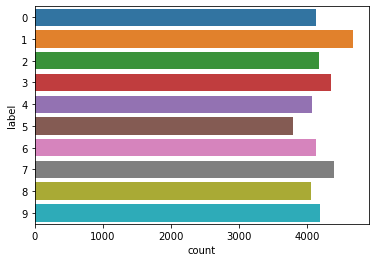

In [5]:
sns.countplot(y=y_train)
y_train.value_counts().sort_index(ascending=True)

In [6]:
### We can see that we have a similar counts for the 10 digits

In [7]:
print("X_train Shape:",X_train.shape)
print("y_train Shape:", y_train.shape)


X_train Shape: (42000, 784)
y_train Shape: (42000,)


### 2.2 Check for null and missing values

In [8]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [9]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

#### There are no missing values in the train and test dataset. So, can safely go ahead.

### 2.3 Normalization

We perform a Grayscale normalization to reduce the effect of illumination's differences.

Moreover the CNN converge faster on [0..1] data rather than on[0.. 255]

In [10]:
# NOrmalize the data
X_train= X_train/255.0
test=test/255.0

Text(0.5, 0.98, 'Darkgrid images')

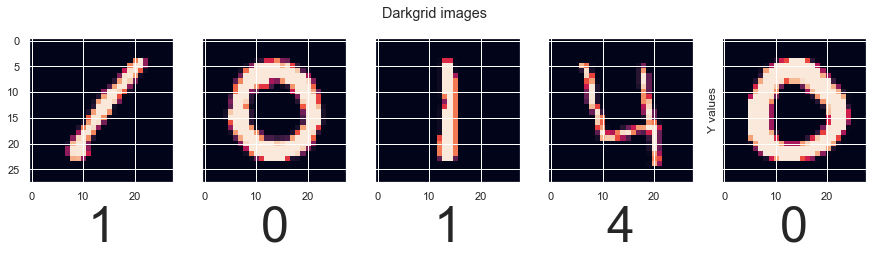

In [33]:
#Showing the sample
sns.set(style='darkgrid')
# plt.style.use('grayscale')
fig, axs = plt.subplots(1, 5, figsize=(15,3), sharey=True)
ax=axs.ravel()

for i in range(5): 
        ax[i].imshow(images[i].reshape(28,28))
        ax[i].set_xlabel(np.argmax(y_train[i]),{'fontsize':50})
        
# plt.ylabel("Y values")

fig.suptitle('Darkgrid images')

### 2.4 Reshape

In [16]:
## Lets Reshape image in 3 dimensions (h = 28px , w= 28px, channel=1)
X_train = X_train.values.reshape(X_train.shape[0],28,28,1) #reshape(-1,28,28,1)
test=test.values.reshape(test.shape[0],28,28,1) #reshape(-1,28,28,1)

Train and test images (28px x 28px) has been stock into pandas.Dataframe as 1D vectors of 784 values. We reshape all data to 28x28x1 3D matrices.

Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices.

### 2.5 Label Encoding

In [19]:
# #Encode Labels to one hot vectors
# from sklearn.preprocessing import LabelBinarizer
# lb=LabelBinarizer()
# sd=lb.fit_transform(y_train)
# print(sd)
# sd.shape

[[0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


(42000, 10)

#### (OR)

In [22]:
y_train = to_categorical(y_train, num_classes = 10)
print(y_train)
y_train.shape

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


(42000, 10)

Labels are 10 digits numbers from 0 to 9. We need to encode these lables to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]).

### 2.6 Split Training and validation set

In [38]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=31)

#Stratify = True

I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model.

Since we have 42 000 training images of balanced labels (see 2.1 Load data), a random split of the train set doesn't cause some labels to be over represented in the validation set. Be carefull with some unbalanced dataset a simple random split could cause inaccurate evaluation during the validation.

To avoid that, you could use stratify = True option in train_test_split function (Only for >=0.17 sklearn versions).

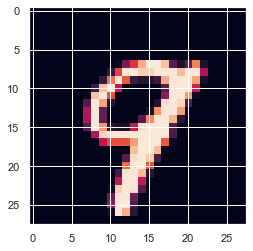

In [42]:
plt.imshow(X_train[2][:,:,0])

### 3. CNN

In [44]:
test.shape

(28000, 28, 28, 1)

. Here we import keras models which contains two types: Sequential model which we’ll be using in this tutorial and The model with the Functional API
I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 32 filters for the two firsts conv2D layers and 64 filters for the two last ones. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample.  This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in two fully-connected (Dense) layers which is just artificial an neural networks (ANN) classifier. In the last layer(Dense(10,activation="softmax")) the net outputs distribution of probability of each class.

In [49]:
## Set the CNN Model
# My CNN Architecture is Input-->[[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model= Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu',input_shape=(28,28,1)))
model.add(Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

### 3.2 Set the Optimizer and Annealer

Once our layers are added to the model, we need to set up a score function, a loss function and an optimisation algorithm.

We define the loss function to measure how poorly our model performs on images with known labels. It is the error rate between the oberved labels and the predicted ones. We use a specific form for categorical classifications (>2 classes) called the "categorical_crossentropy".

The most important function is the optimizer. This function will iteratively improve parameters (filters kernel values, weights and bias of neurons ...) in order to minimise the loss.

I choosed 'Adam Optimizer'(with default values), it is a very effective optimizer,
The Adam Optimizer take both (RMSprop & Gradient Descent with Momentum) Optimization Algorithms
Its a simplest and optimium way to reduce the loss with updating optimum weight and bias parameters. We could also have used Stochastic Gradient Descent ('sgd') optimizer,RMSprop but it is slower than 
Adam Optimizer.

The metric function "accuracy" is used is to evaluate the performance our model. This metric function is similar to the loss function, except that the results from the metric evaluation are not used when training the model (only for evaluation).

In [50]:
#Define the optimizer
optimizer=Adam(learning_rate=0.001, beta_1=0.9,beta_2=0.999,amsgrad=False)

In [51]:
#Compile the model
model.compile(optimizer= optimizer, loss= "categorical_crossentropy", metrics=["accuracy"])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

Its better to have a decreasing learning rate during the training to reach efficiently the global minimum of the loss function.

To keep the advantage of the fast computation time with a high LR, i decreased the LR dynamically every X steps (epochs) depending if it is necessary (when accuracy is not improved).

With the ReduceLROnPlateau function from Keras.callbacks, i choose to reduce the LR by half if the accuracy is not improved after 3 epochs.

In [52]:
#Set a learning rate annealer
learning_rate_reduction=ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

### 3.3 Data Augmentation

In order to avoid overfitting problem, we need to expand artificially our handwritten digit dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations occuring when someone is writing a digit.

For example, the number is not centered The scale is not the same (some who write with big/small numbers) The image is rotated...

Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more.

By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

The improvement is important :

Without data augmentation i obtained an accuracy of 98.114%
With data augmentation i achieved 99.67% of accuracy

In [53]:
# Without data augmentation i obtained an accuracy of 0.98114

#history = model.fit(X_train, Y_train, batch_size = 64, epochs = 30, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [54]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

For the data augmentation, i choosed to :

Randomly rotate some training images by 10 degrees

Randomly Zoom by 10% some training images

Randomly shift images horizontally by 10% of the width

Randomly shift images vertically by 10% of the height

I did not apply a vertical_flip nor horizontal_flip since it could have lead to misclassify symetrical numbers such as 6 and 9.

Once our model is ready, we fit the training dataset .

1.We pass the rescale option to the ImageDataGenerator object. The rescale=1./255 option is a very IMPORTANT parameter. It normalizes the image pixel values to have zero mean and standard deviation of 1. It helps your model to generally learn and update its parameters efficiently.

2.The second set of options is Image augmentation. They tell the ImageDataGenerator to randomly apply some transformation to the Image. This will help to augment our data-set and improve generalization.

3.Here we also create an ImageDataGenerator object for our validation set. Note: we don’t do data augmentation here. We only perform rescale.

4.We pass the rescale option to the ImageDataGenerator object. The rescale=1./255 option is a very IMPORTANT parameter. It normalizes the image pixel values to have zero mean and standard deviation of 1. It helps your model to generally learn and update its parameters efficiently.

5.The second set of options is Image augmentation. They tell the ImageDataGenerator to randomly apply some transformation to the Image. This will help to augment our data-set and improve generalization.

6.Here we also create an ImageDataGenerator object for our validation set. Note: we don’t do data augmentation here. We only perform rescale.

In [58]:
batch_size=64
epochs=30

In [ ]:
# #Fit the Model
# history=model.fit_generator(datagen.flow(X_train,Y_train,batch_size=batch_size),epochs=30,
#                            validation_data=(X_val,Y_val),verbose=4,steps_per_epoch=X_train.shape[0] // batch_size
#                               , callbacks=[learning_rate_reduction])

1.We call the .flow( ) method on the data generators we created above passing in the data and label set.

2.X_train and y_train for training then X_val and y_val for validation.

3.The batch size tells the data generator to only take the specified batch(64 in our case) of Images at a time.

In [60]:
# I usually also include an earlystopper callback in most of my scripts to avoid running excessive epochs.

from keras.callbacks import EarlyStopping

earlystopper = EarlyStopping(monitor='val_loss', min_delta=0,
                             patience=3, verbose=1, mode='auto')

# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction, earlystopper])

Epoch 1/30
 - 177s - loss: 0.1178 - accuracy: 0.9652 - val_loss: 0.0305 - val_accuracy: 0.9910
Epoch 2/30
 - 141s - loss: 0.0947 - accuracy: 0.9726 - val_loss: 0.0272 - val_accuracy: 0.9905
Epoch 3/30
 - 134s - loss: 0.0790 - accuracy: 0.9765 - val_loss: 0.0258 - val_accuracy: 0.9924
Epoch 4/30
 - 134s - loss: 0.0723 - accuracy: 0.9789 - val_loss: 0.0286 - val_accuracy: 0.9917
Epoch 5/30
 - 133s - loss: 0.0637 - accuracy: 0.9806 - val_loss: 0.0211 - val_accuracy: 0.9936
Epoch 6/30
 - 135s - loss: 0.0609 - accuracy: 0.9810 - val_loss: 0.0219 - val_accuracy: 0.9940
Epoch 7/30
 - 134s - loss: 0.0592 - accuracy: 0.9818 - val_loss: 0.0222 - val_accuracy: 0.9929
Epoch 8/30
 - 133s - loss: 0.0520 - accuracy: 0.9840 - val_loss: 0.0312 - val_accuracy: 0.9914
Epoch 00008: early stopping


### EarlyStopping
One technique to reduce overfitting in neural networks is to use early stopping. Early stopping prevents overtraining of your model by terminating the training process if it’s not really learning anything. This is pretty flexible — you can control what metric to monitor, how much it needs to change to be considered “still learning”, and how many epochs in a row it can falter before the model stops training.

1.After training a Keras model, it always calculates and saves the metric we specified when we compiled our model in a variable called history. We can extract these values and plot them.

2.Note: The history object contains all the updates that happened during training.
    
3.Here we simply get the size of our epoch from the number of values in the ‘acc’ list.

4.Here we plot the accuracy against the epoch size.

5.Here we plot the loss against the epoch size.
##### So what can we take away from this plot?

1.The first thing to note is that we’re not overfitting as the train and validation accuracy are pretty close and following each other.

2.We can also notice that the accuracy keeps increasing as the epoch increases, giving us the intuition that increasing the epoch size will likely give us a higher accuracy.

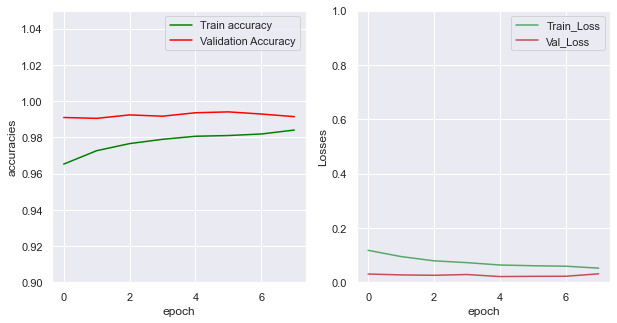

In [71]:
fig=plt.figure(figsize=(10,5))

fig1=fig.add_subplot(121)
plt.plot(history.history['accuracy'],color='Green')
plt.plot(history.history["val_accuracy"],color='red')
plt.ylim(0.90, 1.05)
plt.xlabel("epoch")
plt.ylabel("accuracies")
plt.legend(['Train accuracy','Validation Accuracy'])

fig2=fig.add_subplot(122)
plt.plot(history.history["loss"],color='g')
plt.plot(history.history["val_loss"],color='r')
plt.ylim(0.0, 1)
plt.xlabel("epoch")
plt.ylabel("Losses")
plt.legend(['Train_Loss','Val_Loss'])
plt.show()

Inference:

    1.The train accuracy is 98.40% and validation accuracy is 99.14% from 1 to 8 epochs
    
    2.The validation accuracy is greater than the training accuracy almost evry time during the training. 
    
    3.That means that our model dosen't not overfit the training set.

Our model is very well trained !!!



In [78]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
Y_pred

array([[1.8214713e-06, 7.6152595e-08, 3.7720280e-08, ..., 1.2026812e-13,
        5.2159979e-08, 9.0692975e-10],
       [1.1071438e-11, 7.8111064e-09, 6.9899607e-11, ..., 1.6675074e-10,
        1.2620248e-07, 2.5002265e-04],
       [1.2879657e-21, 1.0581231e-13, 4.7544325e-13, ..., 5.8783998e-14,
        6.4501312e-13, 8.1742848e-13],
       ...,
       [9.9969661e-01, 1.0649236e-06, 1.8268020e-05, ..., 1.6625807e-08,
        1.0659062e-04, 2.0005220e-05],
       [1.9594533e-09, 9.9999964e-01, 4.8811085e-08, ..., 6.7624420e-08,
        3.5808125e-09, 6.2993433e-09],
       [2.2972283e-04, 9.9881750e-01, 1.4230527e-04, ..., 4.4082622e-06,
        2.6402134e-04, 1.2252439e-05]], dtype=float32)

In [76]:
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_pred_classes

array([6, 4, 3, ..., 0, 1, 1], dtype=int64)

In [80]:
Y_true=np.argmax(Y_val,axis=1)
Y_true

array([6, 4, 3, ..., 0, 1, 1], dtype=int64)

In [110]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

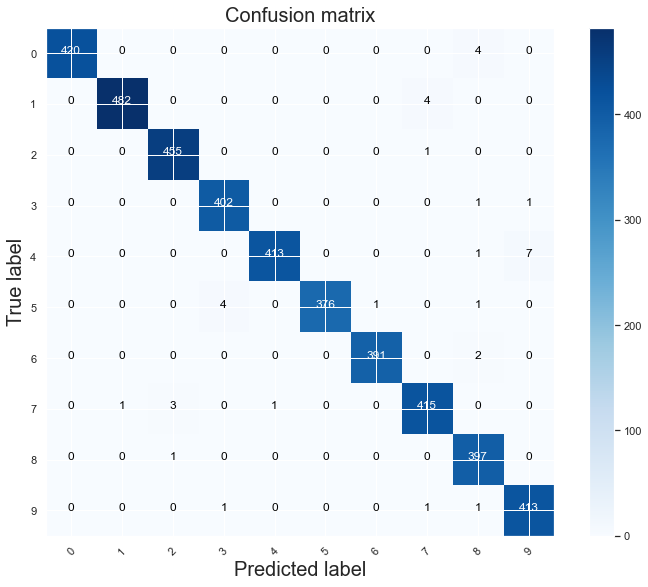

In [111]:
# compute the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plt.figure(figsize=(10,8))
plot_confusion_matrix(confusion_mtx, classes = range(10)) 
plt.show()

In [83]:
confusion_mtx

array([[420,   0,   0,   0,   0,   0,   0,   0,   4,   0],
       [  0, 482,   0,   0,   0,   0,   0,   4,   0,   0],
       [  0,   0, 455,   0,   0,   0,   0,   1,   0,   0],
       [  0,   0,   0, 402,   0,   0,   0,   0,   1,   1],
       [  0,   0,   0,   0, 413,   0,   0,   0,   1,   7],
       [  0,   0,   0,   4,   0, 376,   1,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0, 391,   0,   2,   0],
       [  0,   1,   3,   0,   1,   0,   0, 415,   0,   0],
       [  0,   0,   1,   0,   0,   0,   0,   0, 397,   0],
       [  0,   0,   0,   1,   0,   0,   0,   1,   1, 413]], dtype=int64)

Here we can see that our CNN performs very well on all digits with few errors considering the size of the validation set (4 200 images).

However, it seems that our CNN has some little troubles with the 4 digits, hey are misclassified as 9. Sometime it is very difficult to catch the difference between 4 and 9 when curves are smooth.

In [116]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


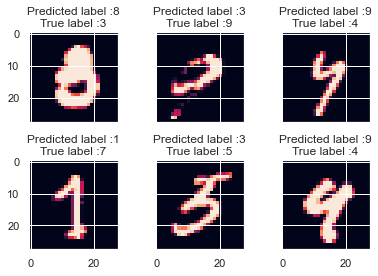

In [122]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
            plt.tight_layout()

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [123]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [124]:
results

0        2
1        0
2        9
3        0
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: Label, Length: 28000, dtype: int64

In [125]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission
# submission.to_csv("cnn_mnist_datagen.csv",index=False)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [126]:
test.shape

(28000, 28, 28, 1)

## THE END